## Crop Model Calibration using MODIS and S2 data

In [ ]:
################################################################################################################
# Developed by Jonathan Ojeda 1/6/2020 TIA-UTAS
# Collaborator: Facundo Della Nave FAUBA
# Code functionalities:
# Compare model simulations with remote sensing products
# This code works with 3 main files:
#df_MODIS
#df_S2
#All_Data
#################################################################################################################

In [1]:
import os
import sqlite3
import datetime
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [39]:
#Read the data for the scatter plot
dfMODISsc=pd.read_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\df_MODIS.csv')
dfS2=pd.read_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\df_S2.csv')

dfS2["Cover_S2NDVI_mean"] = pd.to_numeric(dfS2.Cover_S2NDVI_mean, errors='coerce')
dfS2["RadInt_S2NDVI_mean"] = pd.to_numeric(dfS2.RadInt_S2NDVI_mean, errors='coerce')
dfS2["AGGR_S2NDVI_mean"] = pd.to_numeric(dfS2.AGGR_S2NDVI_mean, errors='coerce')

#Delete MODIS image with issues
dfMODISsc = dfMODISsc[dfMODISsc.SN != '430085_LTi1_00y_20_F']

#Read the data for the line plot
total=pd.read_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\Alldata.csv')

#Create dataframe to calculate statistics avoiding nan values in S2
dfS2clean = dfS2.dropna(subset = ['Cover_S2NDVI_mean','RadInt_S2NDVI_mean','AGGR_S2NDVI_mean',
                                 'Cover_S2SAVI_mean','RadInt_S2SAVI_mean','AGGR_S2SAVI_mean',
                                 'Cover_S2OSAVI_mean','RadInt_S2OSAVI_mean','AGGR_S2OSAVI_mean',
                                 'Cover_S2OSAVI_mean','RadInt_S2OSAVI_mean','AGGR_S2OSAVI_mean'])

dfMODISsc['climate'] = dfMODISsc['SN'].str[:6]
dfMODISsc['soil'] = dfMODISsc['SN'].str[7:11]
dfMODISsc['cultivar'] = dfMODISsc['SN'].str[12:15]
dfMODISsc['harvest'] = dfMODISsc['SN'].str[16:18]
dfMODISsc['prevcrop'] = dfMODISsc['SN'].str[19:20]

dfS2['climate'] = dfS2['SN'].str[:6]
dfS2['soil'] = dfS2['SN'].str[7:11]
dfS2['cultivar'] = dfS2['SN'].str[12:15]
dfS2['harvest'] = dfS2['SN'].str[16:18]
dfS2['prevcrop'] = dfS2['SN'].str[19:20]

## XY APSIM vs MODIS and S2

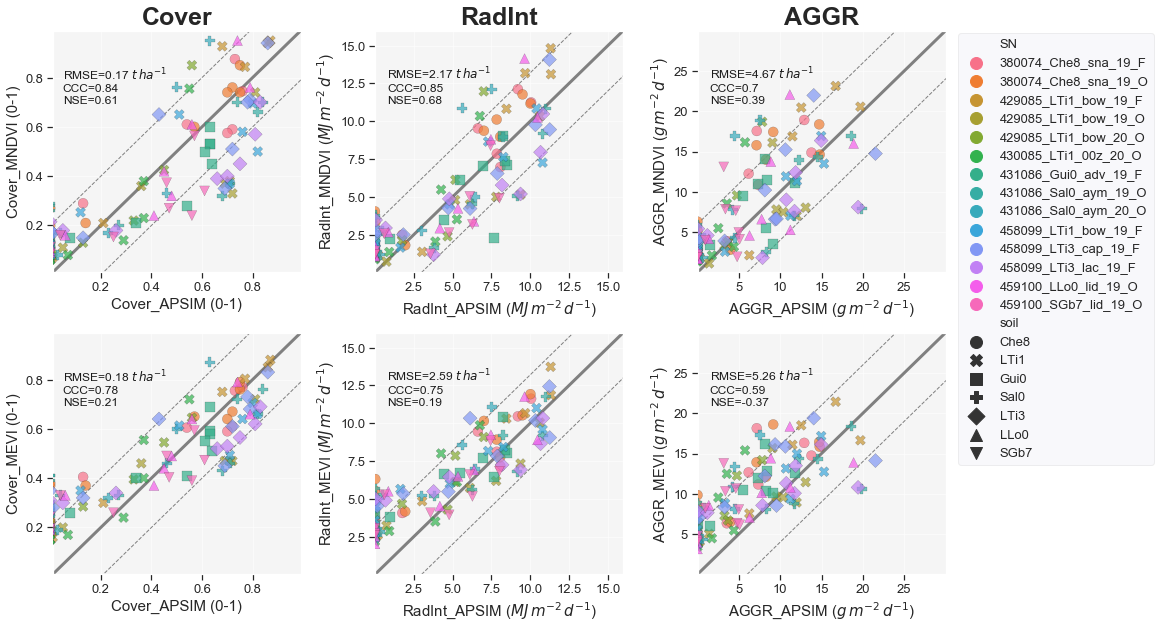

In [36]:
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(16,10))

ax=plt.subplot(2, 3, 1)
ax.set_title('Cover',fontsize= 25,weight='bold') 

xmax=0.99
ymax=0.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[0.2, ymax+0.2],"--",color="grey", linewidth=1,zorder=1)
plt.plot([0.2,xmax+0.2],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="Cover_APSIM_mean", y="Cover_MNDVI_mean",hue='SN', alpha=0.7, data=dfMODISsc,linewidth=0.2,**kwargs,s=100, zorder=3, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3)
plt.ylabel('Cover_MNDVI (0-1)', fontsize =15)
plt.xlabel('Cover_APSIM (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfMODISsc.Cover_MNDVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfMODISsc.Cover_APSIM_mean.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.8,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.75,'CCC='+CCC,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.7,'NSE='+NSE,fontsize=12,color='k')

###################################################################################
ax=plt.subplot(2, 3, 2)
ax.set_title('RadInt',fontsize= 25,weight='bold') 
xmax=15.99
ymax=15.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[3.2,ymax+3.2],"--",color="grey", linewidth=1,zorder=1)
plt.plot([3,xmax+3],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="RadInt_APSIM_mean", y="RadInt_MNDVI_mean",hue='SN', alpha=0.7, data=dfMODISsc,linewidth=0.2,**kwargs,s=100, zorder=3, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('RadInt_MNDVI ($MJ\,m^{-2}\,d^{-1}$)', fontsize =15)
plt.xlabel('RadInt_APSIM ($MJ\,m^{-2}\,d^{-1}$)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfMODISsc.RadInt_MNDVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfMODISsc.RadInt_APSIM_mean.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.8,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.75,'CCC='+CCC,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.7,'NSE='+NSE,fontsize=12,color='k')

####################################################################################
ax=plt.subplot(2, 3, 3)

ax.set_title('AGGR',fontsize= 25,weight='bold') 
xmax=29.99
ymax=29.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[6,ymax+6],"--",color="grey", linewidth=1,zorder=1)
plt.plot([6,xmax+6],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="AGGR_APSIM_mean", y="AGGR_MNDVI_mean",hue='SN', alpha=0.7, data=dfMODISsc,linewidth=0.2,**kwargs,s=100, zorder=3, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=13),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('AGGR_MNDVI ($g\,m^{-2}\,d^{-1}$)', fontsize =15)
plt.xlabel('AGGR_APSIM ($g\,m^{-2}\,d^{-1}$)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list
Obs = pd.Series(dfMODISsc.AGGR_MNDVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfMODISsc.AGGR_APSIM_mean.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.8,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.75,'CCC='+CCC,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.7,'NSE='+NSE,fontsize=12,color='k')

################################################################################################
ax=plt.subplot(2, 3, 4)
xmax=0.99
ymax=0.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[0.2, ymax+0.2],"--",color="grey", linewidth=1,zorder=1)
plt.plot([0.2,xmax+0.2],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="Cover_APSIM_mean", y="Cover_MEVI_mean",hue='SN', alpha=0.7, data=dfMODISsc,linewidth=0.2,**kwargs,s=100, zorder=3, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('Cover_MEVI (0-1)', fontsize =15)
plt.xlabel('Cover_APSIM (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfMODISsc.Cover_MEVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfMODISsc.Cover_APSIM_mean.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.8,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.75,'CCC='+CCC,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.7,'NSE='+NSE,fontsize=12,color='k')

############################################################################################################
ax=plt.subplot(2, 3, 5)
xmax=15.99
ymax=15.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[3.2,ymax+3.2],"--",color="grey", linewidth=1,zorder=1)
plt.plot([3,xmax+3],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="RadInt_APSIM_mean", y="RadInt_MEVI_mean",hue='SN', alpha=0.7, data=dfMODISsc,linewidth=0.2,**kwargs,s=100, zorder=3, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('RadInt_MEVI ($MJ\,m^{-2}\,d^{-1}$)', fontsize =15)
plt.xlabel('RadInt_APSIM ($MJ\,m^{-2}\,d^{-1}$)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfMODISsc.RadInt_MEVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfMODISsc.RadInt_APSIM_mean.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.8,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.75,'CCC='+CCC,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.7,'NSE='+NSE,fontsize=12,color='k')

###########################################################################################################
ax=plt.subplot(2, 3, 6)
xmax=29.99
ymax=29.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[6,ymax+6],"--",color="grey", linewidth=1,zorder=1)
plt.plot([6,xmax+6],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="AGGR_APSIM_mean", y="AGGR_MEVI_mean", hue='SN', alpha=0.7, data=dfMODISsc,linewidth=0.2,**kwargs,s=100, zorder=3, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('AGGR_MEVI ($g\,m^{-2}\,d^{-1}$)', fontsize =15)
plt.xlabel('AGGR_APSIM ($g\,m^{-2}\,d^{-1}$)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfMODISsc.AGGR_MEVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfMODISsc.AGGR_APSIM_mean.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.8,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.75,'CCC='+CCC,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.7,'NSE='+NSE,fontsize=12,color='k')

######################################################################################
plt.subplots_adjust(wspace=0.3, hspace=0.25)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\XY_MODISvsAPSIM.png', dpi=300,bbox_inches='tight')

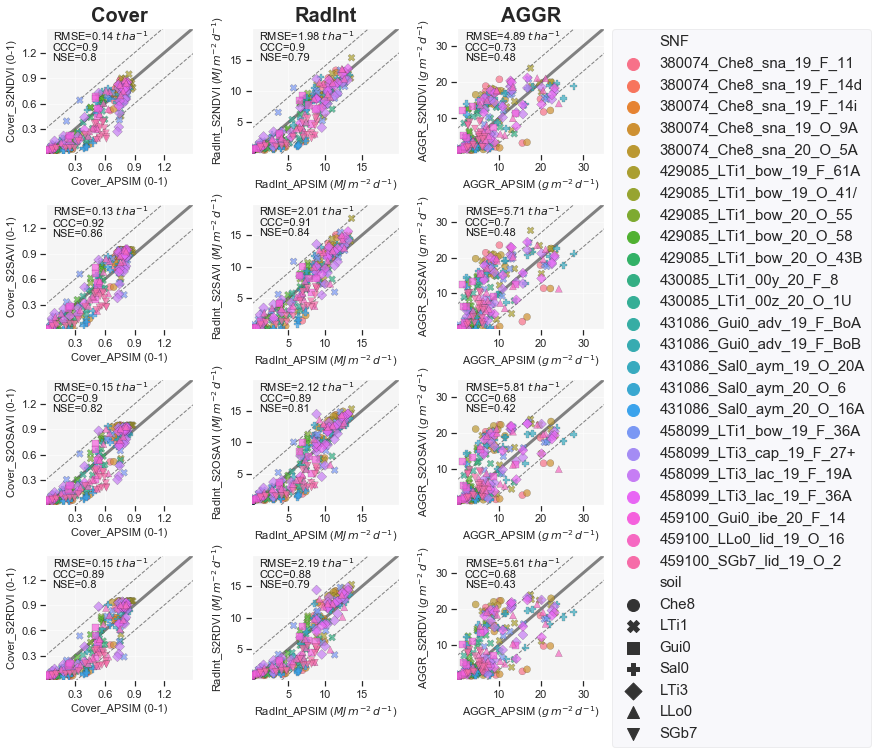

In [37]:
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(10,12))

################################################################################################
ax=plt.subplot(4, 3, 1)
ax.set_title('Cover',fontsize= 20,weight='bold') 
xmax=1.49
ymax=1.49
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[0.3, ymax+0.3],"--",color="grey", linewidth=1,zorder=1)
plt.plot([0.3,xmax+0.3],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="Cover_APSIM", y="Cover_S2NDVI_mean",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs, zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('Cover_S2NDVI (0-1)', fontsize =11)
plt.xlabel('Cover_APSIM (0-1)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.Cover_S2NDVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

############################################################################################################
ax=plt.subplot(4, 3, 2)
ax.set_title('RadInt',fontsize= 20,weight='bold') 
xmax=19.99
ymax=19.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[4,ymax+4],"--",color="grey", linewidth=1,zorder=1)
plt.plot([4,xmax+4],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="RadInt_APSIM", y="RadInt_S2NDVI_mean",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs,zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('RadInt_S2NDVI ($MJ\,m^{-2}\,d^{-1}$)', fontsize =11)
plt.xlabel('RadInt_APSIM ($MJ\,m^{-2}\,d^{-1}$)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.RadInt_S2NDVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.RadInt_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

###########################################################################################################
ax=plt.subplot(4, 3, 3)
ax.set_title('AGGR',fontsize= 20,weight='bold') 
xmax=34.99
ymax=34.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[7,ymax+7],"--",color="grey", linewidth=1,zorder=1)
plt.plot([7,xmax+7],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(y="AGGR_S2NDVI_mean", x="AGGR_APSIM",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs, zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3, markerscale=2)
plt.ylabel('AGGR_S2NDVI ($g\,m^{-2}\,d^{-1}$)', fontsize =11)
plt.xlabel('AGGR_APSIM ($g\,m^{-2}\,d^{-1}$)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.AGGR_S2NDVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.AGGR_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

################################################################################################
ax=plt.subplot(4, 3, 4)
xmax=1.49
ymax=1.49
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[0.3, ymax+0.3],"--",color="grey", linewidth=1,zorder=1)
plt.plot([0.3,xmax+0.3],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="Cover_APSIM", y="Cover_S2SAVI_mean",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs, zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('Cover_S2SAVI (0-1)', fontsize =11)
plt.xlabel('Cover_APSIM (0-1)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.Cover_S2SAVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

############################################################################################################
ax=plt.subplot(4, 3, 5)
xmax=19.99
ymax=19.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[4,ymax+4],"--",color="grey", linewidth=1,zorder=1)
plt.plot([4,xmax+4],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="RadInt_APSIM", y="RadInt_S2SAVI_mean",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs,zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('RadInt_S2SAVI ($MJ\,m^{-2}\,d^{-1}$)', fontsize =11)
plt.xlabel('RadInt_APSIM ($MJ\,m^{-2}\,d^{-1}$)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.RadInt_S2SAVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.RadInt_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

###########################################################################################################
ax=plt.subplot(4, 3, 6)
xmax=34.99
ymax=34.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[7,ymax+7],"--",color="grey", linewidth=1,zorder=1)
plt.plot([7,xmax+7],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(y="AGGR_S2SAVI_mean", x="AGGR_APSIM",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs, zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('AGGR_S2SAVI ($g\,m^{-2}\,d^{-1}$)', fontsize =11)
plt.xlabel('AGGR_APSIM ($g\,m^{-2}\,d^{-1}$)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.AGGR_S2SAVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.AGGR_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

################################################################################################
ax=plt.subplot(4, 3, 7)
xmax=1.49
ymax=1.49
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[0.3, ymax+0.3],"--",color="grey", linewidth=1,zorder=1)
plt.plot([0.3,xmax+0.3],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="Cover_APSIM", y="Cover_S2OSAVI_mean",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs, zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('Cover_S2OSAVI (0-1)', fontsize =11)
plt.xlabel('Cover_APSIM (0-1)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.Cover_S2OSAVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

############################################################################################################
ax=plt.subplot(4, 3, 8)
xmax=19.99
ymax=19.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[4,ymax+4],"--",color="grey", linewidth=1,zorder=1)
plt.plot([4,xmax+4],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="RadInt_APSIM", y="RadInt_S2OSAVI_mean",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs,zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('RadInt_S2OSAVI ($MJ\,m^{-2}\,d^{-1}$)', fontsize =11)
plt.xlabel('RadInt_APSIM ($MJ\,m^{-2}\,d^{-1}$)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.RadInt_S2OSAVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.RadInt_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

###########################################################################################################
ax=plt.subplot(4, 3, 9)
xmax=34.99
ymax=34.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[7,ymax+7],"--",color="grey", linewidth=1,zorder=1)
plt.plot([7,xmax+7],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(y="AGGR_S2OSAVI_mean", x="AGGR_APSIM",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs, zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('AGGR_S2OSAVI ($g\,m^{-2}\,d^{-1}$)', fontsize =11)
plt.xlabel('AGGR_APSIM ($g\,m^{-2}\,d^{-1}$)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.AGGR_S2OSAVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.AGGR_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

################################################################################################
ax=plt.subplot(4, 3, 10)
xmax=1.49
ymax=1.49
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[0.3, ymax+0.3],"--",color="grey", linewidth=1,zorder=1)
plt.plot([0.3,xmax+0.3],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="Cover_APSIM", y="Cover_S2RDVI_mean",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs, zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('Cover_S2RDVI (0-1)', fontsize =11)
plt.xlabel('Cover_APSIM (0-1)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.Cover_S2RDVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

############################################################################################################
ax=plt.subplot(4, 3, 11)
xmax=19.99
ymax=19.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[4,ymax+4],"--",color="grey", linewidth=1,zorder=1)
plt.plot([4,xmax+4],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(x="RadInt_APSIM", y="RadInt_S2RDVI_mean",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs,zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('RadInt_S2RDVI ($MJ\,m^{-2}\,d^{-1}$)', fontsize =11)
plt.xlabel('RadInt_APSIM ($MJ\,m^{-2}\,d^{-1}$)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.RadInt_S2RDVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.RadInt_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

###########################################################################################################
ax=plt.subplot(4, 3, 12)
xmax=34.99
ymax=34.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[7,ymax+7],"--",color="grey", linewidth=1,zorder=1)
plt.plot([7,xmax+7],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
sns.scatterplot(y="AGGR_S2RDVI_mean", x="AGGR_APSIM",hue='SNF', alpha=0.7, data=dfS2,linewidth=0.2,**kwargs, zorder=3, s=50, style='soil')

# Formatting graph and background
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('AGGR_S2RDVI ($g\,m^{-2}\,d^{-1}$)', fontsize =11)
plt.xlabel('AGGR_APSIM ($g\,m^{-2}\,d^{-1}$)', fontsize =11)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=11)
ax.xaxis.set_tick_params(labelsize=11)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dfS2clean.AGGR_S2RDVI_mean.values)
y_o= Obs.tolist()
Pre = pd.Series(dfS2clean.AGGR_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values


plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC,fontsize=11,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE,fontsize=11,color='k')

######################################################################################
plt.subplots_adjust(wspace=0.4, hspace=0.4)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\XY_S2vsAPSIM.png', dpi=300,bbox_inches='tight')

## **Line plots with all data**

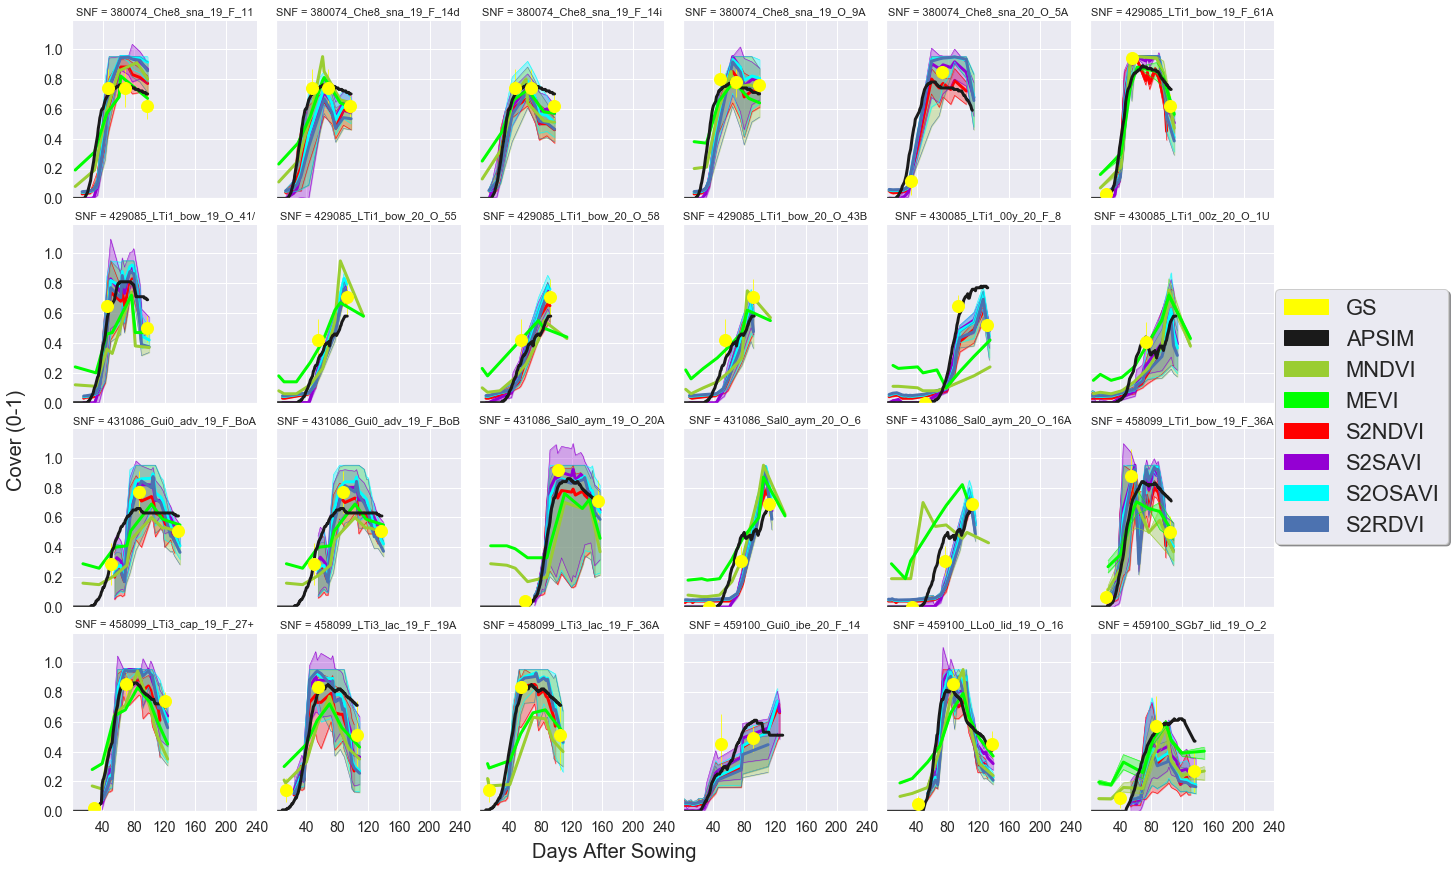

In [38]:
sns.set(font_scale=1)
g = sns.FacetGrid(total, col="SNF", col_wrap=6, height=3)

#S2NDVI data
g.map(plt.plot, "DAS", "Cover_S2NDVI_mean", linestyle="-",linewidth=3,color='red')
g.map(plt.plot, "DAS", "Cover_S2NDVI_max", linestyle="-",linewidth=0.5,color='red')
g.map(plt.plot, "DAS", "Cover_S2NDVI_min", linestyle="-",linewidth=0.5,color='red')
g.map(plt.fill_between, "DAS", "Cover_S2NDVI_min","Cover_S2NDVI_max", interpolate=True, color='red',alpha=0.3)

#S2SAVI data
g.map(plt.plot, "DAS", "Cover_S2SAVI_mean", linestyle="-",linewidth=3,color='darkviolet')
g.map(plt.plot, "DAS", "Cover_S2SAVI_max", linestyle="-",linewidth=0.5,color='darkviolet')
g.map(plt.plot, "DAS", "Cover_S2SAVI_min", linestyle="-",linewidth=0.5,color='darkviolet')
g.map(plt.fill_between, "DAS", "Cover_S2SAVI_min","Cover_S2SAVI_max", interpolate=True, color='darkviolet',alpha=0.3)

#S2OSAVI data
g.map(plt.plot, "DAS", "Cover_S2OSAVI_mean", linestyle="-",linewidth=3,color='cyan')
g.map(plt.plot, "DAS", "Cover_S2OSAVI_max", linestyle="-",linewidth=0.5,color='cyan')
g.map(plt.plot, "DAS", "Cover_S2OSAVI_min", linestyle="-",linewidth=0.5,color='cyan')
g.map(plt.fill_between, "DAS", "Cover_S2OSAVI_min","Cover_S2OSAVI_max", interpolate=True, color='cyan',alpha=0.3)

#S2RDVI data
g.map(plt.plot, "DAS", "Cover_S2RDVI_mean", linestyle="-",linewidth=3,color='b')
g.map(plt.plot, "DAS", "Cover_S2RDVI_max", linestyle="-",linewidth=0.5,color='b')
g.map(plt.plot, "DAS", "Cover_S2RDVI_min", linestyle="-",linewidth=0.5,color='b')
g.map(plt.fill_between, "DAS", "Cover_S2RDVI_min","Cover_S2RDVI_max", interpolate=True, color='yellowgreen',alpha=0.3)

#MODISNDVI data
g.map(plt.plot, "DAS", "Cover_MNDVI_mean", linestyle="-",linewidth=3,color='yellowgreen')
g.map(plt.plot, "DAS", "Cover_MNDVI_max", linestyle="-",linewidth=0.5,color='yellowgreen')
g.map(plt.plot, "DAS", "Cover_MNDVI_min", linestyle="-",linewidth=0.5,color='yellowgreen')
g.map(plt.fill_between, "DAS", "Cover_MNDVI_min","Cover_MNDVI_max", interpolate=True, color='yellowgreen',alpha=0.3)

#MODISEVI data
g.map(plt.plot, "DAS", "Cover_MEVI_mean", linestyle="-",linewidth=3,color='lime')
g.map(plt.plot, "DAS", "Cover_MEVI_max", linestyle="-",linewidth=0.5,color='lime')
g.map(plt.plot, "DAS", "Cover_MEVI_min", linestyle="-",linewidth=0.5,color='lime')
g.map(plt.fill_between, "DAS", "Cover_MEVI_min","Cover_MEVI_max", interpolate=True, color='lime',alpha=0.3)

#APSIM data
g.map(plt.plot, "DAS", "Cover_APSIM", linestyle="-",linewidth=3,color='k')

#GREENSEEKER data
ax = g.map(plt.errorbar, "DAS", "Cover_Obs", "CoverError", fmt ='o',marker='',zorder=1,color='yellow',linewidth=0.8)
g.map(plt.plot, "DAS", "Cover_Obs", linestyle="",linewidth=3,color='yellow',marker='o',markersize=12)

#Legend
import matplotlib.patches as mpatches
yellow_patch = mpatches.Patch(color='yellow', label='GS')
black_patch = mpatches.Patch(color='k', label='APSIM')
yellowgreen_patch = mpatches.Patch(color='yellowgreen', label='MNDVI')
lime_patch = mpatches.Patch(color='lime', label='MEVI')

red_patch = mpatches.Patch(color='red', label='S2NDVI')
violet_patch = mpatches.Patch(color='darkviolet', label='S2SAVI')
cyan_patch = mpatches.Patch(color='cyan', label='S2OSAVI')
b_patch = mpatches.Patch(color='b', label='S2RDVI')


plt.legend(handles=[yellow_patch, black_patch, yellowgreen_patch, lime_patch, red_patch, violet_patch, cyan_patch, b_patch], 
           bbox_to_anchor=(2, 3), fancybox=True, shadow=True, ncol=1, fontsize=22)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,240])
    ax.set_ylim([0,1.19])

g.fig.text(-0.01, 0.43,'Cover (0-1)', fontsize=20, rotation=90)
g.fig.text(0.395, 0,'Days After Sowing', fontsize=20)
g.fig.text(0.9, 1,'', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\all.png', dpi=300,bbox_inches='tight')

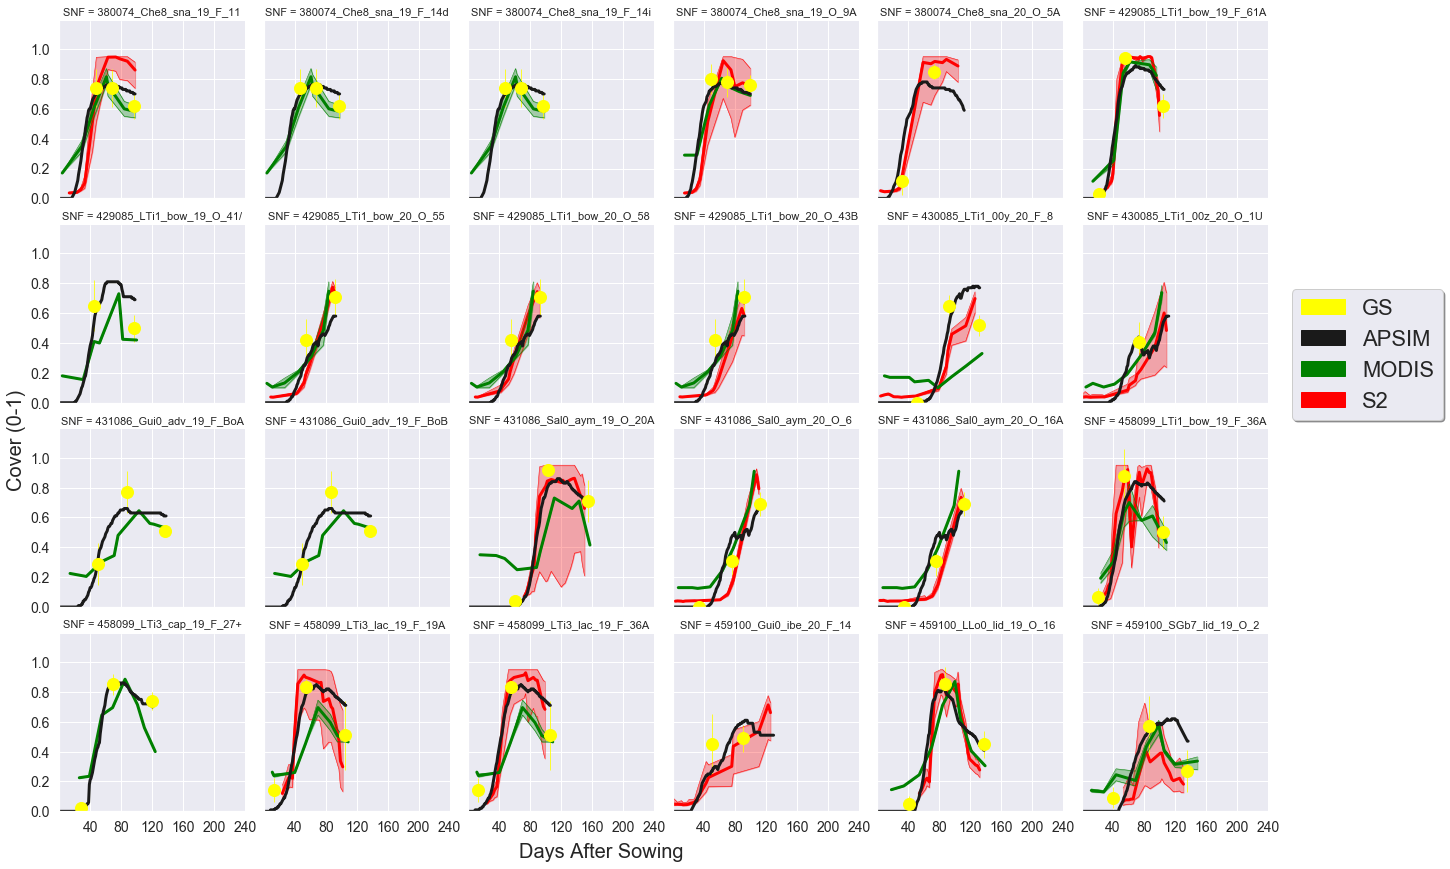

In [35]:
sns.set(font_scale=1)
g = sns.FacetGrid(total, col="SNF", col_wrap=6, height=3)

#S2 data
g.map(plt.plot, "DAS", "Cover_S2_median", linestyle="-",linewidth=3,color='red')
g.map(plt.plot, "DAS", "Cover_S2_max", linestyle="-",linewidth=0.5,color='red')
g.map(plt.plot, "DAS", "Cover_S2_min", linestyle="-",linewidth=0.5,color='red')
g.map(plt.fill_between, "DAS", "Cover_S2_min","Cover_S2_max", interpolate=True, color='red',alpha=0.3)

#MODIS data
g.map(plt.plot, "DAS", "Cover_M_median", linestyle="-",linewidth=3,color='green')
g.map(plt.plot, "DAS", "Cover_M_max", linestyle="-",linewidth=0.5,color='green')
g.map(plt.plot, "DAS", "Cover_M_min", linestyle="-",linewidth=0.5,color='green')
g.map(plt.fill_between, "DAS", "Cover_M_min","Cover_M_max", interpolate=True, color='green',alpha=0.3)

#APSIM data
g.map(plt.plot, "DAS", "Cover_APSIM", linestyle="-",linewidth=3,color='k')

#GREENSEEKER data
ax = g.map(plt.errorbar, "DAS", "Cover_Obs", "CoverError", fmt ='o',marker='',zorder=1,color='yellow',linewidth=0.8)
g.map(plt.plot, "DAS", "Cover_Obs", linestyle="",linewidth=3,color='yellow',marker='o',markersize=12)

#Legend
import matplotlib.patches as mpatches
yellow_patch = mpatches.Patch(color='yellow', label='GS')
black_patch = mpatches.Patch(color='k', label='APSIM')
green_patch = mpatches.Patch(color='green', label='MODIS')
red_patch = mpatches.Patch(color='red', label='S2')

plt.legend(handles=[yellow_patch, black_patch, green_patch, red_patch], 
           bbox_to_anchor=(2, 3), fancybox=True, shadow=True, ncol=1, fontsize=22)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,240])
    ax.set_ylim([0,1.19])

g.fig.text(0, 0.43,'Cover (0-1)', fontsize=20, rotation=90)
g.fig.text(0.395, 0,'Days After Sowing', fontsize=20)
g.fig.text(0.9, 1,'', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\all.png', dpi=300,bbox_inches='tight')

## Cover APSIM vs MODIS

In [ ]:
sns.set(font_scale=1)
kw = {'color' : ["r","green"]}
g = sns.FacetGrid(dfMODIS, col="SN", col_wrap=5, height=3, ylim=(0, 1), hue='source',hue_order=["APSIM", "MODIS"], hue_kws=kw)

g.map(plt.plot, "date", "Cover_mean", linestyle="-",linewidth=3).add_legend(prop=dict(size=12),
                                                                             bbox_to_anchor=(0.98, 0.74), 
                                                                             borderaxespad=0., ncol=1,framealpha=0.3)
g.map(plt.plot, "date", "Cover_min", linestyle="--",linewidth=1)
g.map(plt.plot, "date", "Cover_max", linestyle="--",linewidth=1)
g.map(plt.fill_between, "date", "Cover_min","Cover_max", interpolate=True,alpha=0.3)

#.add_legend()

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title())
    # This only works for the left ylabels
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')

g.fig.subplots_adjust(wspace=0.03, hspace=.15)
g.fig.text(0.01, 0.43,'Cover MODIS-APSIM (0-1)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'MODIS Image Order (0-10)', fontsize=16)
g.fig.text(0.73, 1,'Cover APSIM vs MODIS', fontsize=25, fontweight="bold")
#from matplotlib.lines import Line2D
#custom_lines = [Line2D([0], [0], color='r', lw=3),
#                Line2D([0], [0], color='green', lw=3)]

#for ax in g.axes.ravel():
#    ax.legend(custom_lines, ['APSIM', 'MODIS'])

#g.add_legend(title = 'Data Source', prop={'size': 15}, bbox_to_anchor=(0.2, 0.8))
#for ax in g.axes.ravel():
#    ax.legend()

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\modis.png', dpi=300,bbox_inches='tight')

## Cover APSIM vs S2

In [ ]:
sns.set(font_scale=1)
g = sns.FacetGrid(dfS2, col="SNF", col_wrap=6, height=3, ylim=(0, 1))

g.map(plt.plot, "date", "Cover_APSIM", linestyle="-",linewidth=3,color='r')
g.map(plt.plot, "date", "Cover_S2_mean", linestyle="-",linewidth=3,color='green')
g.map(plt.plot, "date", "Cover_S2_min", linestyle="--",linewidth=1,color='green')
g.map(plt.plot, "date", "Cover_S2_max", linestyle="--",linewidth=1,color='green')
g.map(plt.fill_between, "date", "Cover_S2_min","Cover_S2_max", interpolate=True, color='green',alpha=0.3)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='APSIM')
blue_patch = mpatches.Patch(color='green', label='S2')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(5.4, 5.6), fancybox=True, shadow=True)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

g.fig.subplots_adjust(wspace=0.1, hspace=.15)
g.fig.text(0.01, 0.43,'Cover S2-APSIM (0-1)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.77, 1,'Cover APSIM vs S2', fontsize=25, fontweight="bold")

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\s2.png', dpi=300,bbox_inches='tight')

## RadInt APSIM vs MODIS

In [ ]:
#Read the MODIS and APSIM data
dfMODIS=pd.read_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\df_MODIS_v2.csv')

sns.set(font_scale=1)
kw = {'color' : ["r","green"]}
g = sns.FacetGrid(dfMODIS, col="SN", col_wrap=5, height=3, ylim=(0, 15), hue='source',hue_order=["APSIM", "MODIS"], hue_kws=kw)

g.map(plt.plot, "date", "RadInt_mean", linestyle="-",linewidth=3).add_legend(prop=dict(size=12),
                                                                             bbox_to_anchor=(0.98, 0.92), 
                                                                             borderaxespad=0., ncol=1,framealpha=0.3)
g.map(plt.plot, "date", "RadInt_min", linestyle="--",linewidth=1)
g.map(plt.plot, "date", "RadInt_max", linestyle="--",linewidth=1)
g.map(plt.fill_between, "date", "RadInt_min","RadInt_max", interpolate=True,alpha=0.3)


# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title())
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')

g.fig.subplots_adjust(wspace=0.03, hspace=.15)
g.fig.text(0.01, 0.43,'RadInt MODIS-APSIM (0-1)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'MODIS Image Order (0-10)', fontsize=16)
g.fig.text(0.73, 1,'RadInt APSIM vs MODIS', fontsize=25, fontweight="bold")

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\modis.png', dpi=300,bbox_inches='tight')

## RadInt APSIM vs S2

In [ ]:
sns.set(font_scale=1)
g = sns.FacetGrid(dfS2, col="SNF", col_wrap=6, height=3, ylim=(0, 17.5))

g.map(plt.plot, "date", "RadInt_APSIM", linestyle="-",linewidth=3,color='r')
g.map(plt.plot, "date", "RadInt_S2_mean", linestyle="-",linewidth=3,color='green')
g.map(plt.plot, "date", "RadInt_S2_min", linestyle="--",linewidth=1,color='green')
g.map(plt.plot, "date", "RadInt_S2_max", linestyle="--",linewidth=1,color='green')
g.map(plt.fill_between, "date", "RadInt_S2_min","RadInt_S2_max", interpolate=True, color='green',alpha=0.3)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='APSIM')
blue_patch = mpatches.Patch(color='green', label='S2')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(5.4, 5.6), fancybox=True, shadow=True)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    # This only works for the left ylabels
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

g.fig.subplots_adjust(wspace=0.1, hspace=.15)
g.fig.text(0.01, 0.43,'RadInt S2-APSIM (0-1)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.77, 1,'RadInt APSIM vs S2', fontsize=25, fontweight="bold")

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\s2.png', dpi=300,bbox_inches='tight')

## AGGR APSIM vs MODIS

In [ ]:
#Read the MODIS and APSIM data
dfMODIS=pd.read_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\df_MODIS_v2.csv')

sns.set(font_scale=1)
kw = {'color' : ["r","green"]}
g = sns.FacetGrid(dfMODIS, col="SN", col_wrap=5, height=3, ylim=(0, 30), hue='source',hue_order=["APSIM", "MODIS"], hue_kws=kw)

g.map(plt.plot, "date", "AGGR_mean", linestyle="-",linewidth=3).add_legend(prop=dict(size=12),
                                                                             bbox_to_anchor=(0.98, 0.92), 
                                                                             borderaxespad=0., ncol=1,framealpha=0.3)
g.map(plt.plot, "date", "AGGR_min", linestyle="--",linewidth=1)
g.map(plt.plot, "date", "AGGR_max", linestyle="--",linewidth=1)
g.map(plt.fill_between, "date", "AGGR_min","AGGR_max", interpolate=True,alpha=0.3)

#.add_legend()

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title())
    # This only works for the left ylabels
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')

g.fig.subplots_adjust(wspace=0.03, hspace=.15)
g.fig.text(0.01, 0.43,'AGGR MODIS-APSIM (0-1)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'MODIS Image Order (0-10)', fontsize=16)
g.fig.text(0.73, 1,'AGGR APSIM vs MODIS', fontsize=25, fontweight="bold")

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\modis.png', dpi=300,bbox_inches='tight')

## AGGR APSIM vs S2

In [ ]:
sns.set(font_scale=1)
g = sns.FacetGrid(dfS2, col="SNF", col_wrap=6, height=3, ylim=(0, 30))

g.map(plt.plot, "date", "AGGR_APSIM", linestyle="-",linewidth=3,color='r')
g.map(plt.plot, "date", "AGGR_S2_mean", linestyle="-",linewidth=3,color='green')
g.map(plt.plot, "date", "AGGR_S2_min", linestyle="--",linewidth=1,color='green')
g.map(plt.plot, "date", "AGGR_S2_max", linestyle="--",linewidth=1,color='green')
g.map(plt.fill_between, "date", "AGGR_S2_min","AGGR_S2_max", interpolate=True, color='green',alpha=0.3)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='APSIM')
blue_patch = mpatches.Patch(color='green', label='S2')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(5.4, 5.6), fancybox=True, shadow=True)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    # This only works for the left ylabels
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

g.fig.subplots_adjust(wspace=0.1, hspace=.15)
g.fig.text(0.01, 0.43,'AGGR S2-APSIM (0-1)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.77, 1,'AGGR APSIM vs S2', fontsize=25, fontweight="bold")

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\s2.png', dpi=300,bbox_inches='tight')

## Comparison between pixel MODIS with different covers

In [ ]:
#Read the MODIS and APSIM data
dfMODIS=pd.read_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\comp.csv')

sns.set(font_scale=1)
kw = {'color' : ["r","green"]}
g = sns.FacetGrid(dfMODIS, col="Intercept", col_wrap=5, height=5, ylim=(0, 1), hue='source',hue_order=["APSIM", "MODIS"], hue_kws=kw)

g.map(plt.plot, "date", "Cover_mean", linestyle="-",linewidth=3)
g.map(plt.plot, "date", "Cover_min", linestyle="--",linewidth=1)
g.map(plt.plot, "date", "Cover_max", linestyle="--",linewidth=1)

#.add_legend()

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize='large')
    # This only works for the left ylabels
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')

g.fig.subplots_adjust(wspace=0.03, hspace=.15)
g.fig.text(0.005, 0.3,'Cover MODIS-APSIM (0-1)', fontsize=16, rotation=90)
g.fig.text(0.17, 0.01,'MODIS Image Order (0-10)', fontsize=16)
g.fig.text(0.06, 1,'Cover APSIM vs MODIS for different pixel covers', fontsize=25, fontweight="bold")
#from matplotlib.lines import Line2D
#custom_lines = [Line2D([0], [0], color='r', lw=3),
#                Line2D([0], [0], color='green', lw=3)]

#for ax in g.axes.ravel():
#    ax.legend(custom_lines, ['APSIM', 'MODIS'])

#g.add_legend(title = 'Data Source', prop={'size': 15}, bbox_to_anchor=(0.2, 0.8))
#for ax in g.axes.ravel():
#    ax.legend()

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\modis.png', dpi=300,bbox_inches='tight')